In [184]:
import numpy as np
import healpy as hp
import utils
import matplotlib.pyplot as plt
import imp

from utils import smooth as smooth
from utils import deconv as deconv

from PurifyB import PurifyB

%matplotlib inline

## Parameters

In [19]:
lmax = 1000; nside = 512

In [257]:
def Cross_TT(maps, lmax):
    
    ''' 
        revised for upper-triangle of the matrix 
        
    Input: spin-1 maps
    '''
    n_f = len(maps)
    cl = np.zeros((n_f*n_f, lmax + 1)); Cl = np.zeros((lmax+1, n_f, n_f))
    
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            if i >= j :
                cl[k] = hp.anafast(maps[i], maps[j], lmax = lmax)
            else:
                cl[k] = np.zeros(lmax+1)
            k += 1
            
    for l in range(lmax+1):
        Cl[l, 0:n_f , 0:n_f] = cl[:,l].reshape(n_f, n_f)
        Cl[l] += Cl[l].T - np.diag(Cl[l].diagonal()) 
    return Cl

# ILC using information of Covariance matrix

In [15]:
bl95 = hp.gauss_beam(fwhm=19.0/60/180*np.pi, lmax = 2550)

In [11]:
clbb_th = np.loadtxt('cls_r_0p05.txt')[2]

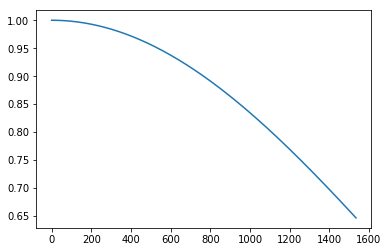

In [21]:
pl = hp.pixwin(512)
plt.plot(pl)

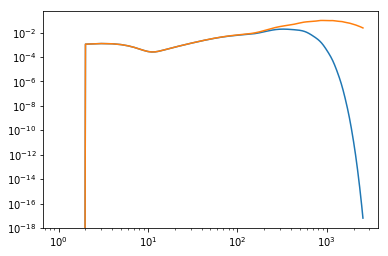

In [17]:
elte = np.arange(len(clbb_th)); elt2 = utils.l2(elte);
plt.loglog(elte, elt2*clbb_th*bl95**2)
plt.loglog(elte, elt2*clbb_th)

## Data

### noise power spectrum

In [322]:
path = '/fnx/jianyao/ancillary_data/0420_ILC_P/'

SamNum = 100; Q = lmax + 1 #vlen(ps_e.ell_n) 
Nf  = 3
noise_ps_mean = np.zeros((Q, Nf, Nf))

for n in range(SamNum):
    noise_ps_mean += np.load('%s/Nl_bb/nl_cross_bb_%s.npy'%(path, n))

noise_ps_mean /= SamNum

# np.save('%s/Nl_bb/noise_ps_mean.npy'%path, noise_ps_mean)

In [37]:
ali_ma_512 = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits')

cl_clean = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_bb_95GHz_LH.npy')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


### foreground residual 

#### singal component in simulation

> add beam effect to be the same with the input foreground for the ILC method

In [228]:
## uK_CMB, 2048, 0.0 arcmin
sync_95 = hp.ud_grade(smooth(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/synchrotron_map_95GHz.fits', field = None, verbose = False), beam_out = 19, lmax = lmax + 100), nside_out=nside)
sync_150 = hp.ud_grade(smooth(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/synchrotron_map_150GHz.fits', field = None, verbose = False), beam_out = 11, lmax = lmax + 100), nside_out=nside)

## K_CMB, 2048, 0.0 arcmin
sync_353 = 1e6*hp.ud_grade(smooth(hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/synchrotron_map_detector_F353.fits',field = None, verbose = False), beam_out = 4.944, lmax = lmax + 100), nside_out=nside)

## uK_CMB, 2048, 0.0 arcmin
dust_95 = hp.ud_grade(smooth(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/thermaldust_map_95GHz.fits', field = None, verbose = False), beam_out = 19, lmax = lmax + 100), nside_out=nside)
dust_150 = hp.ud_grade(smooth(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/thermaldust_map_150GHz.fits', field = None, verbose = False), beam_out = 11, lmax = lmax + 100), nside_out=nside)

## K_CMB, 2048, 0.0 arcmin
dust_353 = 1e6*hp.ud_grade(smooth(hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/thermaldust_map_detector_F353.fits', field = None, verbose = False), beam_out = 4.944, lmax = lmax + 100), nside_out=nside)

> deconvolve the foreground

In [229]:
Sync = np.zeros((Nf, 3, 12*nside**2))
Sync[0] = sync_95;
Sync[1] = deconv(sync_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100)
Sync[2] = deconv(sync_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) 

Dust = np.zeros((Nf, 3, 12*nside**2))
Dust[0] = dust_95;
Dust[1] = deconv(dust_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100)
Dust[2] = deconv(dust_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) 

In [230]:
syncBB = np.zeros((Nf, 12*nside**2)); dustBB = np.zeros((Nf, 12*nside**2));

for fre in range(Nf):
    purify_sync = PurifyB(Sync[fre], ali_ma_512);
    syncBB[fre] = purify_sync.lin_resi();
    
    purify_dust = PurifyB(Dust[fre], ali_ma_512);
    dustBB[fre] = purify_dust.lin_resi();

#### total foreground

In [181]:
g2_95 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits',field = None, verbose = False)

g2_150 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits',field = None, verbose = False)

g2_353 = hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits',field = None, verbose = False)

In [182]:
### 19 arcmin, uK_CMB
fore95 = hp.ud_grade(g2_95 , nside_out=512)   #+ g3_95

### 11 arcmin, uK_CMB
fore150 = hp.ud_grade(g2_150, nside_out=512)  #+ g3_150
 ###4.944 arcmin, K_CMB
fore353 = hp.ud_grade(g2_353, nside_out=512)*1e6  #+ g3_353

In [186]:
beam_low = 19

In [189]:
Fore = np.zeros((Nf, 3, 12*nside**2)); ForeBB = np.zeros((Nf, 12*nside**2))

Fore[0] = fore95 
Fore[1] = deconv(fore150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100) 
Fore[2] = deconv(fore353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) 

In [190]:
for fre in range(Nf):
    purify = PurifyB(Fore[fre], ali_ma_512)
    ForeBB[fre] = purify.lin_resi()

### ILC in pixel space

In [134]:
import ABS_ILC_class

imp.reload(ABS_ILC_class)

from ABS_ILC_class import ILC_BB
from ABS_ILC_class import ILC_we

In [324]:
W = np.zeros((SamNum, Nf)); Cl = np.zeros((SamNum, lmax + 1)); Cl_we = np.zeros((SamNum, lmax + 1)); W_we = np.zeros((SamNum, Nf))

In [325]:
for i in range(SamNum):
    
    total_cl = np.load('/fnx/jianyao/ancillary_data/0420_ILC_P/Cl_bb/cross_bb_%03d.npy'%i)
    total_map = np.load('/fnx/jianyao/ancillary_data/0420_ILC_P/total_map_unmasked/total_BBmap_deconv_unmasked_%03d.npy'%i)
    
    ilc_bb = ILC_BB(total_map, ali_ma_512)
    
    cmb_cleaned = ilc_bb.run()[0]; W[i] = ilc_bb.run()[1]
    Cl[i] = hp.anafast(cmb_cleaned, lmax = lmax)

    ilc_we = ILC_we(total_map, total_cl, cl_clean, ali_ma_512)
    
    cmb_clean_we = ilc_we.run()[0]; W_we[i] = ilc_we.run()[1]
    Cl_we[i] = hp.anafast(cmb_clean_we, lmax = lmax)
    
cl_ilc_mean = np.mean(Cl, axis = 0);
cl_ilc_std  = np.std(Cl, axis = 0);

cl_we_mean = np.mean(Cl_we, axis = 0);
cl_we_std = np.std(Cl_we, axis = 0);

In [326]:
ell = np.arange(len(cl_ilc_mean)); el2 = utils.l2(ell)

In [327]:
## weight from ILC using convariance matrix 

w = np.matrix(np.mean(W_we, axis = 0))
nl_ps_we = np.zeros(len(ell))

for l in range(len(ell)):
    nl_ps_we[l] = w*np.matrix(noise_ps_mean[l])*w.T

In [328]:
## weight from usual ILC

w_mean = np.matrix(np.mean(W, axis = 0))

nl_ps = np.zeros(len(ell))

for l in range(len(ell)):
    nl_ps[l] = w_mean*(noise_ps_mean[l])*w_mean.T

In [201]:
fore_clean = np.array(np.dot(w_mean, ForeBB))
fore_ilc = hp.anafast(fore_clean, lmax = lmax)

In [331]:
sync_clean = np.array(np.dot(w_mean, syncBB))
sync_ilc = hp.anafast(sync_clean, lmax = lmax);

sync_clean_we = np.array((np.dot(w, syncBB)));
sync_we = hp.anafast(sync_clean_we, lmax = lmax);

dust_clean = np.array(np.dot(w_mean, dustBB));
dust_ilc = hp.anafast(dust_clean, lmax = lmax);

dust_clean_we = np.array(np.dot(w, dustBB));
dust_we = hp.anafast(dust_clean_we, lmax = lmax);

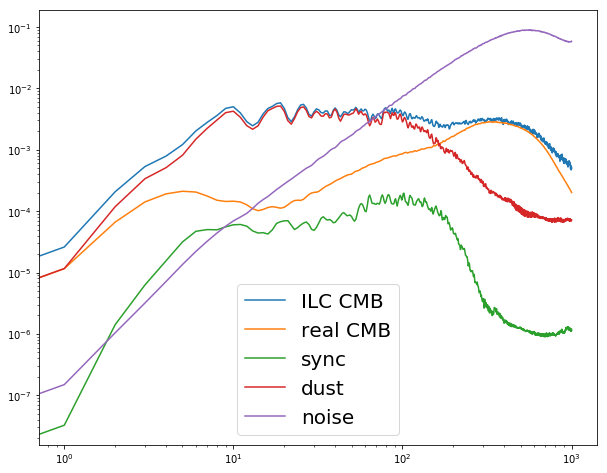

In [332]:
plt.figure(figsize = (10, 8))
plt.loglog(ell, el2*(cl_ilc_mean - nl_ps), label = 'ILC CMB')
plt.loglog(ell, el2*cl_clean, label = 'real CMB')

plt.loglog(ell, el2*(sync_ilc), label = 'sync');
plt.loglog(ell, el2*dust_ilc, label = 'dust');

plt.loglog(ell, el2*(nl_ps), label = 'noise')
plt.legend(fontsize = 20)

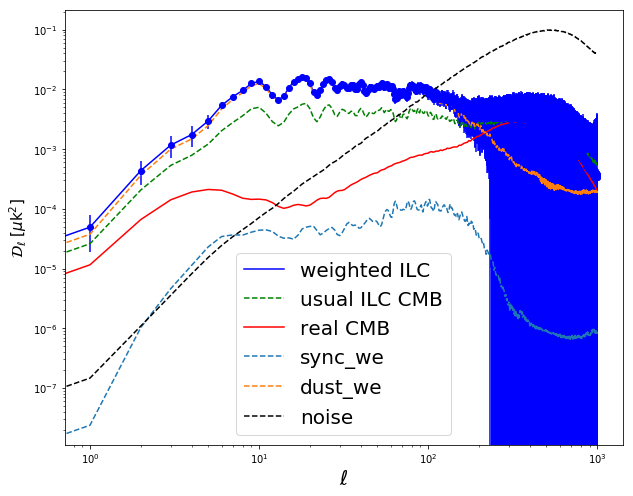

In [338]:
plt.figure(figsize = (10, 8))
# plt.loglog(ell, el2*fore_ilc, label = 'projected foreground')

plt.loglog(ell, el2*(cl_we_mean - nl_ps_we), 'b-', label = 'weighted ILC')
plt.loglog(ell, el2*(cl_ilc_mean - nl_ps),'g--', label = 'usual ILC CMB')
plt.loglog(ell, el2*cl_clean, 'r-', label = 'real CMB')

plt.loglog(ell, el2*(sync_we),'--', label = 'sync_we');
plt.loglog(ell, el2*dust_we, '--',label = 'dust_we');

plt.errorbar(ell, el2*(cl_we_mean - nl_ps_we), yerr = el2*cl_we_std,fmt='bo',capthick = 0.1)

# plt.loglog(ell, el2*nl_ps)
plt.loglog(ell, el2*nl_ps_we, 'k--', label = 'noise')

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)

plt.legend(fontsize = 20)

In [336]:
print('w :',w_mean)
print('w_we :', w)

w : [[ 0.18442579  0.82431567 -0.00874147]]
w_we : [[0.08567577 0.90635693 0.0079673 ]]


### ILC in harmoic space

In [259]:
lmax = 1000

In [260]:
path = '/fnx/jianyao/ancillary_data/4_fre_LH_with_noise_95GHz_beam/'

SamNum = 50; Q = lmax + 1 #len(ps_e.ell_n) #
Nf  = 4
noise_ps_mean = np.zeros((Q, Nf, Nf))

for n in range(SamNum):
    noise_ps_mean += np.load('%s/Nl_bb/nl_cross_bb_%s.npy'%(path, n))

noise_ps_mean /= SamNum

In [271]:
sync_cross = Cross_TT(syncBB, lmax = lmax);
dust_cross = Cross_TT(dustBB, lmax = lmax)

In [274]:
# lmax = 1000,意味着有1001个l,Q应该等于1001; 想要得到干净的天图的时候，
names = ['Q_polarization', 'U_polarization']

sel = np.array((1,2,3)); Nf = len(sel); Q = 50

Cl_ilc = np.zeros((SamNum, Q)); itera = 1; mode = 1; #Fore_cl= np.zeros((SamNum, Q)); sync_cl = np.zeros((SamNum, Q)); dust_cl = np.zeros((SamNum, Q))

sync_hilc = np.zeros((SamNum, Q)); dust_hilc = np.zeros((SamNum, Q))
sync_bin = utils.bin_l(sync_cross, lmax, Q); dust_bin = utils.bin_l(dust_cross, lmax, Q);
for n in range(SamNum): 

    e = np.matrix(np.ones(Nf))
    total_ps_i = np.load('%s/Cl_bb/cross_bb_%03d.npy'%(path, n)) ## only have BB power spectrum for the input maps are pure BB from LH's method.
   
    noise_bin_i = utils.bin_l(noise_ps_mean, lmax, Q); #noise_ps_mean# 
    noise_ilc = np.zeros(Q); 
    total_bin_i = utils.bin_l(total_ps_i, lmax, Q); #total_ps_i #
    
    # take some part of the cross power spectrum matrix
    total_bin = np.ones((Q, Nf,Nf)); noise_bin = np.ones((Q, Nf, Nf)); 
    for q in range(Q):
        x = 0; 
        for i in (sel):
            y = 0;
            for j in (sel):
                
                total_bin[q][x,y] = total_bin_i[q][i, j]
                noise_bin[q][x,y] = noise_bin_i[q][i, j]
                y += 1;
                
            x += 1;
            
    #calculate the weight
    W = np.matrix(np.zeros((Q, Nf)))

    for l in range(Q):
        norm = e*np.linalg.pinv((total_bin[l]))*e.T

        W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   

    for i in range(Q):

        ''' whether include noise_bin or not;  WNW = 1/(eN{-1}e.T)'''

        noise_ilc[i] = W[i,:]*(noise_bin[i])*np.transpose(W[i,:])     #noise_bin　nuisance[i]
        Cl_ilc[n, i] = W[i,:]*(total_bin[i])*np.transpose(W[i,:]) - noise_ilc[i]  #1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) 
        sync_hilc[n, i] = W[i,:]*(sync_bin[i])*np.transpose(W[i,:])
        dust_hilc[n, i] = W[i,:]*(dust_bin[i])*np.transpose(W[i,:])

cl_ilc_mean = np.mean(Cl_ilc, axis = 0)
cl_ilc_std = np.std(Cl_ilc, axis = 0)

cl_mean_std = np.row_stack((cl_ilc_mean, cl_ilc_std))

sync_mean_hilc = np.mean(sync_hilc, axis = 0);
dust_mean_hilc = np.mean(dust_hilc, axis = 0)

In [264]:
Ell = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

In [265]:
cl_clean_bin = utils.bin_l(cl_clean, lmax, Q)

Text(0.5, 1.0, 'Noisy')

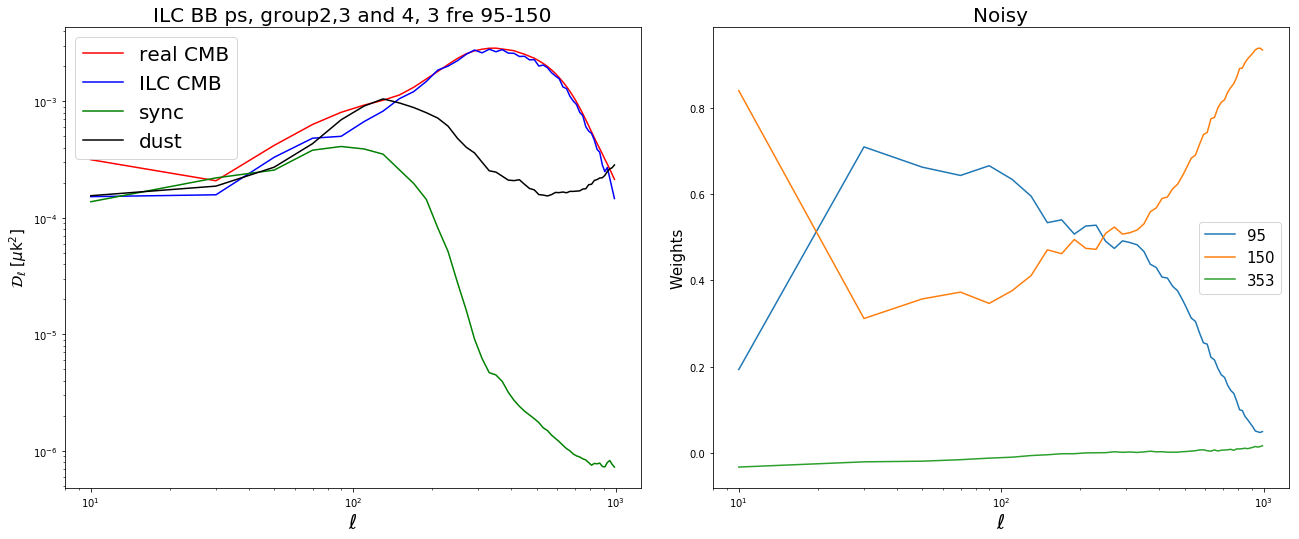

In [278]:
fig1 = plt.figure(1, figsize=(20,8)); psn = ['EE', 'BB']; fre = ['70','95','150','353']; 
# plt.axis('off')
frame1=fig1.add_axes((.1,.1,.4,.8)) # x0, y0, width, height

plt.plot(Ell, el2*cl_clean_bin, 'r-',label = 'real CMB')
# 
plt.plot(Ell, el2*(cl_ilc_mean - sync_mean_hilc - dust_mean_hilc), 'b-', label = 'ILC CMB')

plt.plot(Ell, el2*(sync_mean_hilc), 'g-', label = 'sync')
plt.plot(Ell, el2*(dust_mean_hilc), 'k-', label = 'dust')

plt.xscale('log'); 
plt.yscale('log');

# plt.errorbar(Ell, el2*cl_ilc_mean, yerr = el2*cl_ilc_std,fmt='bo',capthick = 0.1)
# plt.errorbar(Ell, el2*cl_ilc_353, yerr = el2*cl_std_353,fmt='go',capthick = 0.01)

# plt.ylim(1e-4, 1e-1)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20, loc = 'upper left')

plt.title('ILC %s ps, group2,3 and 4, %s fre 95-150'%(psn[mode], Nf), fontsize = 20)
# plt.ylim(2*1e-4, 40)

frame2=fig1.add_axes((.55,.1,.4,.8))
for i in range(Nf):
    plt.plot(Ell, W[:, i], label = '%s'%fre[sel[i]])
plt.xscale('log')
plt.legend(fontsize = 15)
plt.ylabel('Weights', fontsize = 15)
plt.xlabel('$\ell$', fontsize = 20); 
plt.title('Noisy',fontsize = 20)